In [1]:
"""
import sys
!{sys.executable} -m pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html --user
#"""

'\nimport sys\n!{sys.executable} -m pip install torch===1.6.0 torchvision===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html --user\n#'

In [2]:
import torch
torch.__version__

'1.6.0'

In [3]:
torch.cuda.is_available()

False

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import word_tokenize
import re
import nltk

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

st = stopwords.words('english')
stemmer = PorterStemmer()

def loadDataAsDataFrame(f_path):
    '''
        Given a path, loads a data set and puts it into a dataframe
        - simplified mechanism
    '''
    df = pd.read_csv(f_path)
    return df


def preprocess_text(raw_text):

    # Replace/remove username
    raw_text = re.sub('(@[A-Za-z0-9\_]+)', '_atUsername_', raw_text)
    raw_text = re.sub('(http[A-Za-z0-9\_]+)', '_website_', raw_text)
    #stemming and lowercasing
    words=[]
    for w in raw_text.lower().split():
        if not w in st and not w in ['.',',', '[', ']', '(', ')']:
            words.append(w)
            
    return (" ".join(words))

In [5]:
#Load the data
f_path = './Breast Cancer(Raw_data_2_Classes).csv'
data = loadDataAsDataFrame(f_path)

texts = data['Text']
classes = data['Class']
ids = data['ID']

#PREPROCESS THE DATA
texts_preprocessed=[preprocess_text(txt) for txt in texts]
data['preprocessed_texts']=texts_preprocessed

data

,Unnamed: 0,Unnamed: 0.1,ID,Timestamp,Text,Class,preprocessed_texts
0,0,1143,835999046204551168,2017-02-26 23:44:39,my mom could have worked while dying from stag...,0,mom could worked dying stage 4 breast cancer &...
1,2,1981,839261636275933184,2017-03-07 23:49:01,new drug 4 breast cancer is $10k per month. Ca...,0,new drug 4 breast cancer $10k per month. affor...
2,5,1153,853032936324464640,2017-04-14 23:51:15,When people who don't know me try to educate m...,1,people know try educate breast cancer patient ...
3,7,1154,859919598904254464,2017-05-03 23:56:23,This 11 year breast cancer survivor needs heal...,0,11 year breast cancer survivor needs healthcar...
4,9,1159,861368530817732608,2017-05-07 23:53:55,@KellyMazeski Fellow breast cancer survivor he...,0,_atusername_ fellow breast cancer survivor don...
...,...,...,...,...,...,...,...
5014,5991,5991,1235419985733918976,2020-03-05 04:20:52,b'just got back to bk and found out my aunt ha...,0,b'just got back bk found aunt breast cancer da...
5015,5992,5992,1224811121976271104,2020-02-04 21:45:02,b'#iamandiwill \n\ni am strong \ni am loved\ni...,1,b'#iamandiwill \n\ni strong \ni loved\ni alive...
5016,5993,5993,1234769787672302080,2020-03-03 09:17:12,b'@dailymailceleb @dailymailuk lovely see @kyl...,0,b'_atusername_ _atusername_ lovely see _atuser...
5017,5994,5994,1235541633812185088,2020-03-05 12:24:15,b'@drkcain as a breast cancer patient myself f...,1,"b'_atusername_ breast cancer patient 27 yrs, t..."


In [6]:
data.iloc[3]['Text']

'This 11 year breast cancer survivor needs healthcare!  Medicare for all!'

In [7]:
from collections import Counter

Counter(data['Class'])

Counter({0: 3736, 1: 1283})

In [8]:
data['Timestamp']

0       2017-02-26 23:44:39
1       2017-03-07 23:49:01
2       2017-04-14 23:51:15
3       2017-05-03 23:56:23
4       2017-05-07 23:53:55
               ...         
5014    2020-03-05 04:20:52
5015    2020-02-04 21:45:02
5016    2020-03-03 09:17:12
5017    2020-03-05 12:24:15
5018    2020-02-06 19:14:22
Name: Timestamp, Length: 5019, dtype: object

In [9]:
import datetime
import ciso8601

def dateToBetterDatetime(string):
    return ciso8601.parse_datetime(string)#.date()

#returns how many minutes have passed since midnight
def timeOfDay(dtObject):
    tim=dtObject - datetime.datetime(dtObject.year, dtObject.month, dtObject.day)
    return tim.seconds // 60

In [10]:
print(data['Timestamp'][0])
date=dateToBetterDatetime(data['Timestamp'][0])
timeOfDay(date)

2017-02-26 23:44:39


1424

## what about tfidf?

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer()
tfidfvectorizer.fit(texts_preprocessed)

TfidfVectorizer()

In [12]:
tfidfvectorizer.transform(texts_preprocessed[0:3])

<3x14147 sparse matrix of type '<class 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [13]:


word_clusters = {}

def loadwordclusters():
    infile = open('./50mpaths2',  "r", encoding="utf-8")
    for line in infile:
        items = str.strip(line).split()
        class_ = items[0]
        term = items[1]
        word_clusters[term] = class_
    return word_clusters

def getclusterfeatures(sent):
    sent = sent.lower()
    terms = nltk.word_tokenize(sent)
    cluster_string = ''
    for t in terms:
        if t in word_clusters.keys():
                cluster_string += 'clust_' + word_clusters[t] + '_clust '
    return str.strip(cluster_string)

loadwordclusters()

class myVectorizer():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=5000)
        self.tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['Text']
        
        textLens=[]
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
            
        
        self.textVectorizer.fit(texts_preprocessed)
        self.tfidfvectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters) 
        
        self.maxs['len']=max(textLens)
        self.mins['len']=min(textLens)
    
    def transform(self, rows):
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        clusters=[]
        textLens=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        
        tfidf_vectors=self.tfidfvectorizer.transform(texts_preprocessed).toarray()
        data_vectors = np.concatenate((data_vectors, tfidf_vectors), axis=1)
        
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()
        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        textLensNorm=getNormalizedList(textLens, self.maxs['len'], self.mins['len'])
        data_vectors = np.concatenate((data_vectors, np.array([textLensNorm]).T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)


In [14]:
from sklearn.metrics import fbeta_score, make_scorer
#favor precision 2x more than recall
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

In [15]:
def grid_search_hyperparam_space(params, pipeline, folds, training_texts, training_classes):#folds, x_train, y_train, x_validation, y_validation):
        grid_search = GridSearchCV(estimator=pipeline, param_grid=params, refit=True, cv=folds, return_train_score=False, scoring='f1_macro',n_jobs=-1)
        grid_search.fit(training_texts, training_classes)
        return grid_search

## Split the data

In [16]:
from sklearn.model_selection import train_test_split

training_set_size = int(0.8*len(data))

X=data
y=data['Class'].tolist()

training_rows, test_rows, training_classes, test_classes = train_test_split(
    X, y, train_size=training_set_size, random_state=42069)


In [17]:

def normalize(value, maxOfList, minOfList):
    return (value - minOfList) / (maxOfList - minOfList)
    
def getNormalizedList(values, maxOfList, minOfList):
    ret = []
    for value in values:
        ret.append(normalize(value, maxOfList, minOfList))
        
    return ret  

In [18]:
from sklearn.metrics import precision_recall_fscore_support as prf1
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
import random

def bulkEval(predictions_test, test_classes, bs=False):
    print ("Accuracy\t", acc(predictions_test,test_classes))
    macro=f1(predictions_test,test_classes, average='macro')
    micro=f1(predictions_test,test_classes, average='micro')
    FHalf=fbeta_score(predictions_test, test_classes, beta=0.5)
    print ("F1 Macro\t", macro)
    print ("F1 Micro\t", micro)
    print ("FHalf\t", FHalf)
    print("Confusion Matrix")
    print(confusion_matrix(test_classes, predictions_test, labels=[1,0], normalize='true'))

    #bootstrap it
    interval=None
    if bs:
        f1s=[]
        fHalves=[]
        for iteration in range(1000):
            resampleIndexes=random.choices(range(len(predictions_test)), k=1000)
            resamplePreds=[predictions_test[i] for i in resampleIndexes]
            resampleTrueClasses=[test_classes[i] for i in resampleIndexes]
            thisF1=f1(resamplePreds,resampleTrueClasses, average='macro')
            thisFHalf=fbeta_score(resamplePreds,resampleTrueClasses, beta=0.5)
            fHalves.append(thisFHalf)
            f1s.append(thisF1)

        print("Bootstrapping 95% confidence interval for F1:")
        interval=np.percentile(f1s, [2.5, 97.5])
        print(interval)
        print("Bootstrapping 95% confidence interval for FHalf:")
        halfinterval=np.percentile(fHalves, [2.5, 97.5])
        print(halfinterval)

    print("\t****************************************\n")
    
    return macro, micro, interval, FHalf, halfinterval

    #entry={"Classifier": clf, "F1 Macro":macro, "F1 Micro":micro,
    #          "Confidence Interval":interval}
    #f1df=f1df.append(entry, ignore_index=True)

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier


## Guess 0 Classifier
The Stupidest classifier possible

In [20]:
class stupidClassifier():
    def fit(self, X,y):
        doNothing=True
        
    def predict(self, X):
        ret = []
        for xi in X.iterrows():
            ret.append(0)
        return ret

In [21]:
#CLASSIFIER
clf=stupidClassifier()

#CLASSIFY AND EVALUATE 
predictions_test = clf.predict(test_rows)
print('Performance on held-out test set ... :')

bulkEval(predictions_test,test_classes, bs=True)

Performance on held-out test set ... :
Accuracy	 0.7609561752988048
F1 Macro	 0.4321266968325792
F1 Micro	 0.7609561752988048
FHalf	 0.0
Confusion Matrix
[[0. 1.]
 [0. 1.]]
Bootstrapping 95% confidence interval for F1:
[0.42329873 0.44009742]
Bootstrapping 95% confidence interval for FHalf:
[0. 0.]
	****************************************



(0.4321266968325792,
 0.7609561752988048,
 array([0.42329873, 0.44009742]),
 0.0,
 array([0., 0.]))

In [22]:
vectorizer = myVectorizer()

## GNB baseline


In [23]:


#CLASSIFIER
gnb_classifier = GaussianNB()
grid_params = {}

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',gnb_classifier)])

#SEARCH HYPERPARAMETERS
folds = 5
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

bulkEval(predictions_test,test_classes, bs=True)

Performance on held-out test set ... :
Accuracy	 0.6444223107569721
F1 Macro	 0.586774591850734
F1 Micro	 0.6444223107569721
FHalf	 0.5040770941438102
Confusion Matrix
[[0.56666667 0.43333333]
 [0.33115183 0.66884817]]
Bootstrapping 95% confidence interval for F1:
[0.55275705 0.61877457]
Bootstrapping 95% confidence interval for FHalf:
[0.44270445 0.56138875]
	****************************************



(0.586774591850734,
 0.6444223107569721,
 array([0.55275705, 0.61877457]),
 0.5040770941438102,
 array([0.44270445, 0.56138875]))

## simple transformer RoBERTa

In [ ]:
from simpletransformers.classification import ClassificationModel

model_args={'overwrite_output_dir':True}

# Create a TransformerModel
model = ClassificationModel('roberta', 'roberta-base', use_cuda=True, args=model_args)
#model = ClassificationModel('roberta', 'roberta-base', use_cuda=True, args=model_args)

#change our data into a format that simpletransformers can process
training_rows['text']=training_rows['Text']
training_rows['labels']=training_rows['Class']
test_rows['text']=test_rows['Text']
test_rows['labels']=test_rows['Class']

# Train the model
model.train_model(training_rows)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_rows)

print("f1 score")
precision=result['tp'] / (result['tp'] + result['fp'])
recall=result['tp'] / (result['tp'] + result['fn'])
f1score= 2 * precision * recall / (precision + recall)
print(f1score)

# Optimize Parameters

## SVM classifier

Best hyperparameters:
{'svm_classifier__C': 4, 'svm_classifier__kernel': 'rbf'}

In [ ]:
vectorizer = myVectorizer()

#CLASSIFIER
svm_classifier = svm.SVC(gamma='scale')

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('svm_classifier',svm_classifier)])

grid_params = {
     'svm_classifier__C': [0.25,1,4,16,64],
     'svm_classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

#SEARCH HYPERPARAMETERS
folds = 2
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)


#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

In [ ]:
svm_classifier = svm.SVC(gamma='scale')

pipeline = Pipeline(steps = [('vec',vectorizer),('svm_classifier',svm_classifier)])

grid_params = {
     'svm_classifier__C': [4],
     'svm_classifier__kernel': ['rbf'],
}

#SEARCH HYPERPARAMETERS
folds = 2
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(bulkEval(predictions_test,test_classes))

## Random Forest

Best hyperparameters:
{'classifier__n_estimators': 5}

35 for f-half

In [25]:
vectorizer = myVectorizer()

rf = RandomForestClassifier()

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',rf)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)

grid_params = {
     'classifier__n_estimators': np.arange(5,60,5)
}

#SEARCH HYPERPARAMETERS
folds = 2
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

print('Optimal n found:', grid.best_params_['classifier__n_estimators'])

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))


Best hyperparameters:
{'classifier__n_estimators': 35}
Optimal n found: 35
Performance on held-out test set ... :
0.8137450199203188


## KNN

Best hyperparameters:
{'classifier__n_neighbors': 3}
9 for f-half


In [26]:
from sklearn.neighbors import KNeighborsClassifier

vectorizer = myVectorizer()

clf= KNeighborsClassifier()

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)

grid_params = {
     'classifier__n_neighbors': np.arange(1,20,1),
}

#SEARCH HYPERPARAMETERS
folds = 2
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

Best hyperparameters:
{'classifier__n_neighbors': 9}
Performance on held-out test set ... :
0.7798804780876494


## Neural Network

Is it really data science if there isn't a neural network somewhere?

Best hyperparameters:
{'classifier__hidden_layer_sizes': (11,)}

71 for fhalf


In [27]:
from sklearn.neural_network import MLPClassifier

vectorizer = myVectorizer()

clf= MLPClassifier()

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)

#we'll just use one hidden layer
layerParams=[]
for n in range(1,101, 10):
    layerParams.append(tuple([n]))
    
grid_params = {
     'classifier__hidden_layer_sizes': layerParams,
}

#SEARCH HYPERPARAMETERS
folds = 2
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

print(accuracy_score(predictions_test,test_classes))

Best hyperparameters:
{'classifier__hidden_layer_sizes': (71,)}
Performance on held-out test set ... :
0.8227091633466136


## adaboost

Best hyperparameters:
{'classifier__base_estimator__max_depth': 3, 'classifier__base_estimator__n_estimators': 30, 'classifier__n_estimators': 50}

for fhalf
Best hyperparameters:
{'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 30, 'classifier__n_estimators': 50}

In [28]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(), random_state=420)

#SIMPLE PIPELINE
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])
#pipeline ensures vectorization happens in each fold of grid search 
#(you could code the entire process manually for more flexibility)

#we'll just use one hidden layer
layerParams=[]
for n in range(1,101, 10):
    layerParams.append(tuple([n]))
    
grid_params = {
     "classifier__base_estimator__n_estimators":range(10, 51, 20),
     "classifier__base_estimator__max_depth":range(3),
    "classifier__n_estimators":range(10, 51, 20)
}

#SEARCH HYPERPARAMETERS
folds = 2
grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

print('Best hyperparameters:')
print(grid.best_params_)

#CLASSIFY AND EVALUATE 
predictions_test = grid.predict(test_rows)
print('Performance on held-out test set ... :')

bulkEval(predictions_test,test_classes)


Best hyperparameters:
{'classifier__base_estimator__max_depth': 2, 'classifier__base_estimator__n_estimators': 30, 'classifier__n_estimators': 50}
Performance on held-out test set ... :
Accuracy	 0.8456175298804781
F1 Macro	 0.754811366089224
F1 Micro	 0.8456175298804781
Confusion Matrix
[[0.49583333 0.50416667]
 [0.04450262 0.95549738]]
	****************************************



(0.754811366089224, 0.8456175298804781, None)

0.5345911949685536

## Now evaluate them all

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

import random

"""
Confusion matrix whose i-th row and j-th column entry indicates the number of samples 
with true label being i-th class and prediced label being j-th class.
"""

gnb = GaussianNB()
#svmc = svm.SVC(C=4, kernel='rbf', gamma='scale', probability=True)
rf = RandomForestClassifier(n_estimators=5)
knn=KNeighborsClassifier(n_neighbors=3)
nn=MLPClassifier(hidden_layer_sizes=(10,))
ada=AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=30, max_depth=3), n_estimators=50)
en=VotingClassifier(estimators=[ ('RF', rf), #('SVM', svmc),
                                ("KNN", knn), ("NN", nn)], 
                                      voting='soft')

f1df=pd.DataFrame()

for clf in [gnb, rf, knn, nn, ada]:
    vectorizer = myVectorizer()

    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 10
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

    print('Best hyperparameters:')
    print(grid.best_params_)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    print("Classifier\t", clf)

    macro, micro, interval, fhalf, halfinterval=bulkEval(predictions_test, test_classes, bs=True)
    prec=precision_score(predictions_test, test_classes)
    
    entry={"Classifier": clf, "F1 Macro":macro, "F1 Micro":micro,
              "F1 Confidence Interval":interval, "Precision":prec,
          "F-1/2": fhalf, "F-1/2 Confidence Interval": halfinterval}
    f1df=f1df.append(entry, ignore_index=True)
    
f1df

Best hyperparameters:
{}
Classifier	 GaussianNB()
Accuracy	 0.6444223107569721
F1 Macro	 0.586774591850734
F1 Micro	 0.6444223107569721
FHalf	 0.5040770941438102
Confusion Matrix
[[0.56666667 0.43333333]
 [0.33115183 0.66884817]]
Bootstrapping 95% confidence interval for F1:
[0.55743126 0.61793022]
Bootstrapping 95% confidence interval for FHalf:
[0.45418486 0.55259402]
	****************************************

Best hyperparameters:
{}
Classifier	 RandomForestClassifier(n_estimators=5)
Accuracy	 0.7908366533864541
F1 Macro	 0.6805047915189205
F1 Micro	 0.7908366533864541
FHalf	 0.44973544973544977
Confusion Matrix
[[0.425      0.575     ]
 [0.09424084 0.90575916]]
Bootstrapping 95% confidence interval for F1:
[0.64587394 0.71672396]
Bootstrapping 95% confidence interval for FHalf:
[0.38851808 0.51212186]
	****************************************

Best hyperparameters:
{}
Classifier	 KNeighborsClassifier(n_neighbors=3)
Accuracy	 0.7529880478087649
F1 Macro	 0.6292643415284924
F1 Micro	

,Classifier,F-1/2,F-1/2 Confidence Interval,F1 Confidence Interval,F1 Macro,F1 Micro,Precision
0,GaussianNB(),0.504077,"[0.45418486436442534, 0.5525940203217854]","[0.5574312640361156, 0.6179302245897679]",0.586775,0.644422,0.566667
1,RandomForestClassifier(n_estimators=5),0.449735,"[0.38851807725832144, 0.5121218554556943]","[0.6458739441195582, 0.7167239556040689]",0.680505,0.790837,0.425000
2,KNeighborsClassifier(n_neighbors=3),0.384615,"[0.3217231751096929, 0.4442740916828397]","[0.5928608237574813, 0.6666162147885939]",0.629264,0.752988,0.366667
3,"MLPClassifier(hidden_layer_sizes=(10,))",0.636969,"[0.5818158326798166, 0.6884810756972113]","[0.7291242424187502, 0.7907933766726869]",0.760785,0.825697,0.637500
4,AdaBoostClassifier(base_estimator=RandomForest...,0.574354,"[0.5129184508509322, 0.6350810149432387]","[0.7411285789032661, 0.8086152139486253]",0.774928,0.855578,0.537500


In [25]:
gnb = GaussianNB()
svmc = svm.SVC(C=4, kernel='rbf', gamma='scale', probability=True)
rf = RandomForestClassifier(n_estimators=5)
knn=KNeighborsClassifier(n_neighbors=3)
nn=MLPClassifier(hidden_layer_sizes=(11,))
en=VotingClassifier(estimators=[ ('RF', rf), #('SVM', svmc),
                                ("KNN", knn), ("NN", nn)], 
                                      voting='soft')

for clf in [svmc, en]:
    vectorizer = myVectorizer()

    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 10
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

    print('Best hyperparameters:')
    print(grid.best_params_)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    print("Classifier\t", clf)

    macro, micro, interval, fhalf, halfinterval=bulkEval(predictions_test, test_classes, bs=True)
    prec=precision_score(predictions_test, test_classes)
    
    entry={"Classifier": clf, "F1 Macro":macro, "F1 Micro":micro,
              "F1 Confidence Interval":interval, "Precision":prec,
          "F-1/2": fhalf, "F-1/2 Confidence Interval": halfinterval}
    f1df=f1df.append(entry, ignore_index=True)
    
f1df

Best hyperparameters:
{}
Classifier	 SVC(C=4, probability=True)
Accuracy	 0.8545816733067729
F1 Macro	 0.7915804081261233
F1 Micro	 0.854581673306773
FHalf	 0.6527303754266212
Confusion Matrix
[[0.6375     0.3625    ]
 [0.07722513 0.92277487]]
Bootstrapping 95% confidence interval for F1:
[0.76064019 0.81964789]
Bootstrapping 95% confidence interval for FHalf:
[0.59671554 0.7038873 ]
	****************************************

Best hyperparameters:
{}
Classifier	 VotingClassifier(estimators=[('RF', RandomForestClassifier(n_estimators=5)),
                             ('KNN', KNeighborsClassifier(n_neighbors=3)),
                             ('NN', MLPClassifier(hidden_layer_sizes=(11,)))],
                 voting='soft')
Accuracy	 0.8396414342629482
F1 Macro	 0.757215102036525
F1 Micro	 0.8396414342629482
FHalf	 0.5662862159789289
Confusion Matrix
[[0.5375     0.4625    ]
 [0.06544503 0.93455497]]
Bootstrapping 95% confidence interval for F1:
[0.72396188 0.78925013]
Bootstrapping 95% co

,Classifier,F-1/2,F-1/2 Confidence Interval,F1 Confidence Interval,F1 Macro,F1 Micro,Precision
0,GaussianNB(),0.504077,"[0.45418486436442534, 0.5525940203217854]","[0.5574312640361156, 0.6179302245897679]",0.586775,0.644422,0.566667
1,RandomForestClassifier(n_estimators=5),0.449735,"[0.38851807725832144, 0.5121218554556943]","[0.6458739441195582, 0.7167239556040689]",0.680505,0.790837,0.425000
2,KNeighborsClassifier(n_neighbors=3),0.384615,"[0.3217231751096929, 0.4442740916828397]","[0.5928608237574813, 0.6666162147885939]",0.629264,0.752988,0.366667
3,"MLPClassifier(hidden_layer_sizes=(10,))",0.636969,"[0.5818158326798166, 0.6884810756972113]","[0.7291242424187502, 0.7907933766726869]",0.760785,0.825697,0.637500
4,AdaBoostClassifier(base_estimator=RandomForest...,0.574354,"[0.5129184508509322, 0.6350810149432387]","[0.7411285789032661, 0.8086152139486253]",0.774928,0.855578,0.537500
5,"SVC(C=4, probability=True)",0.652730,"[0.5967155354326794, 0.7038873046279768]","[0.7606401945755146, 0.819647886952278]",0.791580,0.854582,0.637500
6,"VotingClassifier(estimators=[('RF', RandomFore...",0.566286,"[0.5073431884388397, 0.624418531340504]","[0.723961882516624, 0.7892501336599992]",0.757215,0.839641,0.537500


In [30]:
f1df.to_pickle("clfScores.pickle")

In [37]:
import pickle
f1df=pd.read_pickle("clfScores.pickle")

the precision function isn't working right

i don't know why

 I'll just make the precisions manually from the confusion matrix

In [56]:
precs=[.56/.9, .425/.52, .366/.49, .64/.75, .54/.58, .64/.71, .54/.6]
f1df['Precision']=precs

In [45]:
def roundToHundredths(num):
    return round(num * 100) / 100

In [57]:
f1ci = f1df['F1 Confidence Interval']
f1ci=[[roundToHundredths(a), roundToHundredths(b)] for [a,b] in f1ci]
f1df['F1 Confidence Interval']=f1ci

f1df['F1 Macro'] = [roundToHundredths(x) for x in f1df['F1 Macro']]
f1df['F1 Micro'] = [roundToHundredths(x) for x in f1df['F1 Micro']]
f1df['Precision'] = [roundToHundredths(x) for x in f1df['Precision']]

In [58]:
f1df[['Classifier', 'F1 Confidence Interval', 'F1 Macro', 'F1 Micro', 'Precision']]

,Classifier,F1 Confidence Interval,F1 Macro,F1 Micro,Precision
0,GaussianNB(),"[0.56, 0.62]",0.59,0.64,0.62
1,RandomForestClassifier(n_estimators=5),"[0.65, 0.72]",0.68,0.79,0.82
2,KNeighborsClassifier(n_neighbors=3),"[0.59, 0.67]",0.63,0.75,0.75
3,"MLPClassifier(hidden_layer_sizes=(10,))","[0.73, 0.79]",0.76,0.83,0.85
4,AdaBoostClassifier(base_estimator=RandomForest...,"[0.74, 0.81]",0.77,0.86,0.93
5,"SVC(C=4, probability=True)","[0.76, 0.82]",0.79,0.85,0.90
6,"VotingClassifier(estimators=[('RF', RandomFore...","[0.72, 0.79]",0.76,0.84,0.90


## Ablation Study

In [28]:
class myVectorizer001():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))            
        
        self.textVectorizer.fit(texts_preprocessed)
        self.tfidfvectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters) 
    
    def transform(self, rows):
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        
        tfidf_vectors=self.tfidfvectorizer.transform(texts_preprocessed).toarray()
        data_vectors = np.concatenate((data_vectors, tfidf_vectors), axis=1)
        
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()
        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)
    
class myVectorizer002():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
        #self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['Text']
        
        textLens=[]
        texts_preprocessed = []
        #clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            #clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
            
        
        self.textVectorizer.fit(texts_preprocessed)
        self.tfidfvectorizer.fit(texts_preprocessed)
        #self.clustervectorizer.fit(clusters) 
        
        self.maxs['len']=max(textLens)
        self.mins['len']=min(textLens)
    
    def transform(self, rows):
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        #clusters=[]
        textLens=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            #clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        
        tfidf_vectors=self.tfidfvectorizer.transform(texts_preprocessed).toarray()
        data_vectors = np.concatenate((data_vectors, tfidf_vectors), axis=1)
        
        #cluster_vectors = self.clustervectorizer.transform(clusters).toarray()
        #data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        textLensNorm=getNormalizedList(textLens, self.maxs['len'], self.mins['len'])
        data_vectors = np.concatenate((data_vectors, np.array([textLensNorm]).T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)
    
class myVectorizer003():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        #self.tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['Text']
        
        textLens=[]
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
            
        
        self.textVectorizer.fit(texts_preprocessed)
        #self.tfidfvectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters) 
        
        self.maxs['len']=max(textLens)
        self.mins['len']=min(textLens)
    
    def transform(self, rows):
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        clusters=[]
        textLens=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        
        #tfidf_vectors=self.tfidfvectorizer.transform(texts_preprocessed).toarray()
        #data_vectors = np.concatenate((data_vectors, tfidf_vectors), axis=1)
        
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()
        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        textLensNorm=getNormalizedList(textLens, self.maxs['len'], self.mins['len'])
        data_vectors = np.concatenate((data_vectors, np.array([textLensNorm]).T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)
    
class myVectorizer004():
    def __init__(self):
        #self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
        
        #for normaluzation
        self.maxs={}
        self.mins={}
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['Text']
        
        textLens=[]
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
            
        
        #self.textVectorizer.fit(texts_preprocessed)
        self.tfidfvectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters) 
        
        self.maxs['len']=max(textLens)
        self.mins['len']=min(textLens)
    
    def transform(self, rows):
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        clusters=[]
        textLens=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
            textLens.append(len(word_tokenize(tr)))
        
        #data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        
        tfidf_vectors=self.tfidfvectorizer.transform(texts_preprocessed).toarray()
        data_vectors = tfidf_vectors#np.concatenate((data_vectors, tfidf_vectors), axis=1)
        
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()
        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        textLensNorm=getNormalizedList(textLens, self.maxs['len'], self.mins['len'])
        data_vectors = np.concatenate((data_vectors, np.array([textLensNorm]).T), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)

In [29]:

#clf=svm.SVC(C=4, kernel='rbf', gamma='scale', probability=True)
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=30, max_depth=3), n_estimators=50)


abDF=pd.DataFrame()

for vectorizer in [myVectorizer001(),myVectorizer002(),myVectorizer003(),myVectorizer004()]:

    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 10
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    macro, micro, interval, fhalf, halfinterval=bulkEval(predictions_test, test_classes, bs=True)
    prec=precision_score(predictions_test, test_classes)
    
    entry={"Vectorizer": vectorizer, "F1 Macro":macro, "F1 Micro":micro,
              "F1 Confidence Interval":interval, "Precision":prec,
          "F-1/2": fhalf, "F-1/2 Confidence Interval": halfinterval}
    abDF=abDF.append(entry, ignore_index=True)
    
abDF

Accuracy	 0.8585657370517928
F1 Macro	 0.7775086613190174
F1 Micro	 0.8585657370517928
FHalf	 0.5724508050089445
Confusion Matrix
[[0.53333333 0.46666667]
 [0.03926702 0.96073298]]
Bootstrapping 95% confidence interval for F1:
[0.74470393 0.80694154]
Bootstrapping 95% confidence interval for FHalf:
[0.51357927 0.62665771]
	****************************************

Accuracy	 0.8147410358565738
F1 Macro	 0.6865933151185194
F1 Micro	 0.8147410358565738
FHalf	 0.4066543438077634
Confusion Matrix
[[0.36666667 0.63333333]
 [0.04450262 0.95549738]]
Bootstrapping 95% confidence interval for F1:
[0.6495853  0.72059004]
Bootstrapping 95% confidence interval for FHalf:
[0.34482328 0.46763053]
	****************************************

Accuracy	 0.8565737051792829
F1 Macro	 0.7717720751667003
F1 Micro	 0.8565737051792828
FHalf	 0.5575539568345323
Confusion Matrix
[[0.51666667 0.48333333]
 [0.03664921 0.96335079]]
Bootstrapping 95% confidence interval for F1:
[0.7361446  0.80267375]
Bootstrapping 9

,F-1/2,F-1/2 Confidence Interval,F1 Confidence Interval,F1 Macro,F1 Micro,Precision,Vectorizer
0,0.572451,"[0.5135792749087205, 0.6266577060559199]","[0.7447039328320719, 0.8069415422765013]",0.777509,0.858566,0.533333,<__main__.myVectorizer001 object at 0x000002A8...
1,0.406654,"[0.34482328016810776, 0.4676305307685182]","[0.6495853047534709, 0.7205900413345668]",0.686593,0.814741,0.366667,<__main__.myVectorizer002 object at 0x000002A8...
2,0.557554,"[0.4936464081959879, 0.6170023143646193]","[0.7361446008915001, 0.8026737487854864]",0.771772,0.856574,0.516667,<__main__.myVectorizer003 object at 0x000002A8...
3,0.581916,"[0.5233866713557235, 0.6409224857316485]","[0.7532677657041373, 0.8156159978385782]",0.784936,0.863546,0.541667,<__main__.myVectorizer004 object at 0x000002A8...


In [30]:
class myVectorizer005():
    def __init__(self):
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['Text']
        
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            clusters.append(getclusterfeatures(tr))
            
        self.clustervectorizer.fit(clusters) 

    
    def transform(self, rows):
        unprocessedTexts=rows['Text']
        
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.clustervectorizer.transform(clusters).toarray()        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)
    
class myVectorizer006():
    def __init__(self):
        self.textVectorizer=CountVectorizer(ngram_range=(1, 3), max_features=10000)
        self.clustervectorizer = CountVectorizer(ngram_range=(1,1), max_features=1000)
    
    def fit(self, rows, y=None):
        
        #fall description
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))            
        
        self.textVectorizer.fit(texts_preprocessed)
        self.clustervectorizer.fit(clusters) 

    
    def transform(self, rows):
        unprocessedTexts=rows['Text']
        
        texts_preprocessed = []
        clusters=[]
        for tr in unprocessedTexts:
            # you can do more with the training text here and generate more features...
            texts_preprocessed.append(preprocess_text(tr))
            clusters.append(getclusterfeatures(tr))
        
        data_vectors = self.textVectorizer.transform(texts_preprocessed).toarray()
        
        cluster_vectors = self.clustervectorizer.transform(clusters).toarray()
        data_vectors = np.concatenate((data_vectors, cluster_vectors), axis=1)
        
        return data_vectors
    
    def fit_transform(self, rows, y=None):
        self.fit(rows)
        return self.transform(rows)

In [31]:

#clf=svm.SVC(C=4, kernel='rbf', gamma='scale', probability=True)

#abDF=pd.DataFrame()

for vectorizer in [myVectorizer005(), myVectorizer006()]:

    clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=30, max_depth=3), n_estimators=50)

    
    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 10
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, training_rows,training_classes)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    macro, micro, interval, fhalf, halfinterval=bulkEval(predictions_test, test_classes, bs=True)
    prec=precision_score(predictions_test, test_classes)
    
    entry={"Vectorizer": vectorizer, "F1 Macro":macro, "F1 Micro":micro,
              "F1 Confidence Interval":interval, "Precision":prec,
          "F-1/2": fhalf, "F-1/2 Confidence Interval": halfinterval}
    abDF=abDF.append(entry, ignore_index=True)
    
abDF

Accuracy	 0.8356573705179283
F1 Macro	 0.7448302950486356
F1 Micro	 0.8356573705179283
FHalf	 0.5333333333333333
Confusion Matrix
[[0.5        0.5       ]
 [0.05890052 0.94109948]]
Bootstrapping 95% confidence interval for F1:
[0.71188847 0.77746792]
Bootstrapping 95% confidence interval for FHalf:
[0.47523073 0.59475322]
	****************************************

Accuracy	 0.851593625498008
F1 Macro	 0.7652051762970171
F1 Micro	 0.851593625498008
FHalf	 0.5515695067264574
Confusion Matrix
[[0.5125     0.4875    ]
 [0.04188482 0.95811518]]
Bootstrapping 95% confidence interval for F1:
[0.73251177 0.79622433]
Bootstrapping 95% confidence interval for FHalf:
[0.49408278 0.60978738]
	****************************************



,F-1/2,F-1/2 Confidence Interval,F1 Confidence Interval,F1 Macro,F1 Micro,Precision,Vectorizer
0,0.572451,"[0.5135792749087205, 0.6266577060559199]","[0.7447039328320719, 0.8069415422765013]",0.777509,0.858566,0.533333,<__main__.myVectorizer001 object at 0x000002A8...
1,0.406654,"[0.34482328016810776, 0.4676305307685182]","[0.6495853047534709, 0.7205900413345668]",0.686593,0.814741,0.366667,<__main__.myVectorizer002 object at 0x000002A8...
2,0.557554,"[0.4936464081959879, 0.6170023143646193]","[0.7361446008915001, 0.8026737487854864]",0.771772,0.856574,0.516667,<__main__.myVectorizer003 object at 0x000002A8...
3,0.581916,"[0.5233866713557235, 0.6409224857316485]","[0.7532677657041373, 0.8156159978385782]",0.784936,0.863546,0.541667,<__main__.myVectorizer004 object at 0x000002A8...
4,0.533333,"[0.475230730915623, 0.594753223099031]","[0.7118884689859208, 0.7774679218962482]",0.744830,0.835657,0.500000,<__main__.myVectorizer005 object at 0x000002A8...
5,0.551570,"[0.4940827798503691, 0.6097873816891154]","[0.7325117708027957, 0.7962243345472186]",0.765205,0.851594,0.512500,<__main__.myVectorizer006 object at 0x000002A8...


In [66]:
types= [['Word Clusters', 'TDIDF Vectors', 'Count Vectors'],
       ['Tweet Length', 'TDIDF Vectors', 'Count Vectors'],
       ['Tweet Length', 'Word Clusters', 'Count Vectors'],
       ['Tweet Length', 'Word Clusters', 'TDIDF Vectors'],
       ['Word Clusters'],
       ['Word Clusters', 'Count Vectors']]

abDF['Features Used']=types

In [67]:
f1ci = abDF['F1 Confidence Interval']
f1ci=[[roundToHundredths(a), roundToHundredths(b)] for [a,b] in f1ci]
abDF['F1 Confidence Interval']=f1ci

abDF['F1 Macro'] = [roundToHundredths(x) for x in abDF['F1 Macro']]
abDF['F1 Micro'] = [roundToHundredths(x) for x in abDF['F1 Micro']]

In [68]:
abDF[['Features Used', 'F1 Macro', 'F1 Micro', 'F1 Confidence Interval']]

,Features Used,F1 Macro,F1 Micro,F1 Confidence Interval
0,"[Word Clusters, TDIDF Vectors, Count Vectors]",0.78,0.86,"[0.74, 0.81]"
1,"[Tweet Length, TDIDF Vectors, Count Vectors]",0.69,0.81,"[0.65, 0.72]"
2,"[Tweet Length, Word Clusters, Count Vectors]",0.77,0.86,"[0.74, 0.8]"
3,"[Tweet Length, Word Clusters, TDIDF Vectors]",0.78,0.86,"[0.75, 0.82]"
4,[Word Clusters],0.74,0.84,"[0.71, 0.78]"
5,"[Word Clusters, Count Vectors]",0.77,0.85,"[0.73, 0.8]"


## Training size vs performance (F1 macro)

In [24]:
#clf = svm.SVC(C=4, kernel='rbf', gamma='scale', probability=True)
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=30, max_depth=3), n_estimators=50)

x=[]
y=[]

for frac in np.arange(.1, 1.01, .1):
    
    partial_training_set_size=int(frac*training_set_size)
    partial_training_rows = training_rows.sample(n=partial_training_set_size)
    partial_training_classes=partial_training_rows['Class'].tolist()
    
    vectorizer = myVectorizer()

    #SIMPLE PIPELINE
    pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

    grid_params = {}
    #SEARCH HYPERPARAMETERS
    folds = 5
    grid = grid_search_hyperparam_space(grid_params,pipeline,folds, partial_training_rows,partial_training_classes)

    #CLASSIFY AND EVALUATE 
    predictions_test = grid.predict(test_rows)
    
    x.append(partial_training_set_size)
    y.append(f1(predictions_test,test_classes, average='macro'))


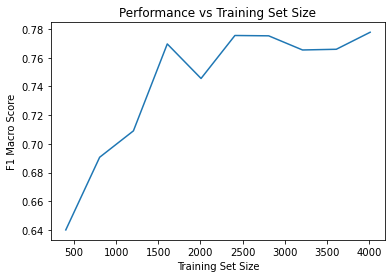

In [26]:
from matplotlib import pyplot as plt

plt.plot(x,y)
plt.title("Performance vs Training Set Size")
plt.ylabel("F1 Macro Score")
plt.xlabel("Training Set Size")
plt.show()

In [ ]:
#from https://www.kite.com/python/answers/how-to-plot-a-linear-regression-line-on-a-scatter-plot-in-python

plt.plot(x, y, 'o')

m, b = np.polyfit(x, y, 1)
plt.title("Performance vs Training Set Size")
plt.ylabel("F1 Macro Score")
plt.xlabel("Training Set Size")
plt.plot(x, [m*xi + b for xi in x])
plt.show()

## The winner: Adaboost RF

with countVector and clusters as features

## PICKLE IT

In [39]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=30, max_depth=3), n_estimators=50)
vectorizer=myVectorizer006()
pipeline = Pipeline(steps = [('vec',vectorizer),('classifier',clf)])

In [40]:
pipeline.fit(data, data['Class'].tolist())

Pipeline(steps=[('vec',
                 <__main__.myVectorizer006 object at 0x000001E0188A2FC8>),
                ('classifier',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=3,
                                                                          n_estimators=30)))])

In [41]:
predictions_test = pipeline.predict(test_rows)
bulkEval(predictions_test, test_classes)

Accuracy	 0.9033864541832669
F1 Macro	 0.8505418143144564
F1 Micro	 0.9033864541832669
FHalf	 0.6876663708961845
Confusion Matrix
[[0.64583333 0.35416667]
 [0.01570681 0.98429319]]
	****************************************



UnboundLocalError: local variable 'halfinterval' referenced before assignment

In [42]:
import pickle

# save the model to disk
filename = 'adaForest11_9_2020.pickle'
pickle.dump(pipeline, open(filename, 'wb'))

# Just give me a function that takes an input and spits out a result

In [ ]:
filename = 'adaForest10_22_2020.pickle'
model = pickle.load(open(filename, 'rb'))

def textToPred(txt):
    inputDF=pd.DataFrame({'Text':[txt]})
    pred=model.predict(inputDF)[0]
    return pred

textToPred("My micro pen is not a self-report")